# DDoS Classification Model

### Jeison Robles Arias

#### Project Goals

The purpose of this notebook is to investigate and recognize important patterns that could be implicated when preventing Distributed Denied of Service in Cybersecurity.

## LIBRARIES

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ipaddress

from sklearn.model_selection import train_test_split                               # for splitting the data set
from sklearn.naive_bayes import GaussianNB                                         # building the model
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [47]:
!pip install imblearn

   -------------------------------------- 258.3/258.3 kB 882.8 kB/s eta 0:00:00


## DATA LOADING

In [2]:
path = r'C:\Users\tan\Documents\final_dataset'

In [4]:
data = pd.read_csv(path + '\_unbalaced_20_80_dataset.csv')

In [5]:
data.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,16/02/2018 11:27:29 PM,8660,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,22/02/2018 12:13:52 AM,5829,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,22/02/2018 12:14:02 AM,3396,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,22/02/2018 12:28:04 AM,2390,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,22/02/2018 12:19:45 AM,17362,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616509 entries, 0 to 7616508
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int64  
 4   Dst IP             object 
 5   Dst Port           int64  
 6   Protocol           int64  
 7   Timestamp          object 
 8   Flow Duration      int64  
 9   Tot Fwd Pkts       int64  
 10  Tot Bwd Pkts       int64  
 11  TotLen Fwd Pkts    float64
 12  TotLen Bwd Pkts    float64
 13  Fwd Pkt Len Max    float64
 14  Fwd Pkt Len Min    float64
 15  Fwd Pkt Len Mean   float64
 16  Fwd Pkt Len Std    float64
 17  Bwd Pkt Len Max    float64
 18  Bwd Pkt Len Min    float64
 19  Bwd Pkt Len Mean   float64
 20  Bwd Pkt Len Std    float64
 21  Flow Byts/s        float64
 22  Flow Pkts/s        float64
 23  Flow IAT Mean      float64
 24  Flow IAT Std       float64
 25  Flow IAT Max      

## FEATURE ENGINEERING

Label values:
Benign    6321980
ddos      1294529
Name: Label, dtype: int64
Bening: 0.830 
DDoS: 0.170


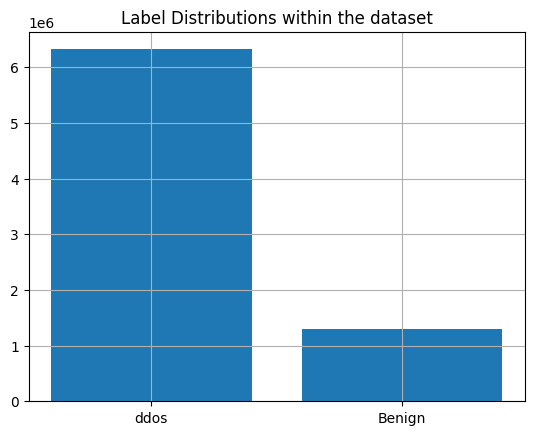

In [37]:
print('Label values:')
print(data["Label"].value_counts())
print('Bening: %.3f ' % (data["Label"].value_counts()[0] / data.shape[0]))
print('DDoS: %.3f' % (data["Label"].value_counts()[1] / data.shape[0]))

plt.bar(x=data['Label'].unique(), height=data['Label'].value_counts())
plt.title('Label Distributions within the dataset')
plt.grid()
plt.show()

## TIME INTELLIGENCE

In [39]:
#Get the entire hour to time analysis
#data['Timestamp'] = pd.to_datetime(data['Timestamp']) 
#data['Hour'] = data['Timestamp'].dt.hour
#data['Year'] = data['Timestamp'].dt.year
#data['Month'] = data['Timestamp'].dt.month
#data['Day'] = data['Timestamp'].dt.day
data['DOW'] = data['Timestamp'].dt.weekday

data.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Hour,Year,Month,Day,DOW
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,2018-02-16 23:27:29,8660,1,...,0.0,0.0,0.0,0.0,ddos,23,2018,2,16,4
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,2018-02-22 00:13:52,5829,4,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,2018-02-22 00:14:02,3396,1,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,2018-02-22 00:28:04,2390,1,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,2018-02-22 00:19:45,17362,4,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3


In [40]:
data['Year'].value_counts()

2018    7181780
2017     423931
2010      10798
Name: Year, dtype: int64

In [41]:
data['Month'].value_counts()

2     7181780
3      352287
4       71644
12       8887
6        1911
Name: Month, dtype: int64

<span style="background-color: yellow;
padding: 2px 5pc;
border-radius: 3px;
font-weght: bold;">Important Data

Note that in the months and years, ther are not continuity, it could means or implicate errors while data extraction from sources, or even when consolidating information in a full file

In [42]:
pivot = pd.pivot_table(data = data[data.Label == 'ddos'],
                       index=('Year','Hour'),
                       #columns=('Protocol'),
                       values = ('Protocol'),
                       aggfunc=(np.count_nonzero)
                       ).reset_index()
pivot

,Year,Hour,Protocol
0,2010,0,819
1,2010,1,158
2,2010,2,65
3,2010,3,167
4,2010,4,225
5,2010,5,188
6,2010,6,96
7,2010,7,150
8,2010,8,89
9,2010,9,660


2010
2018


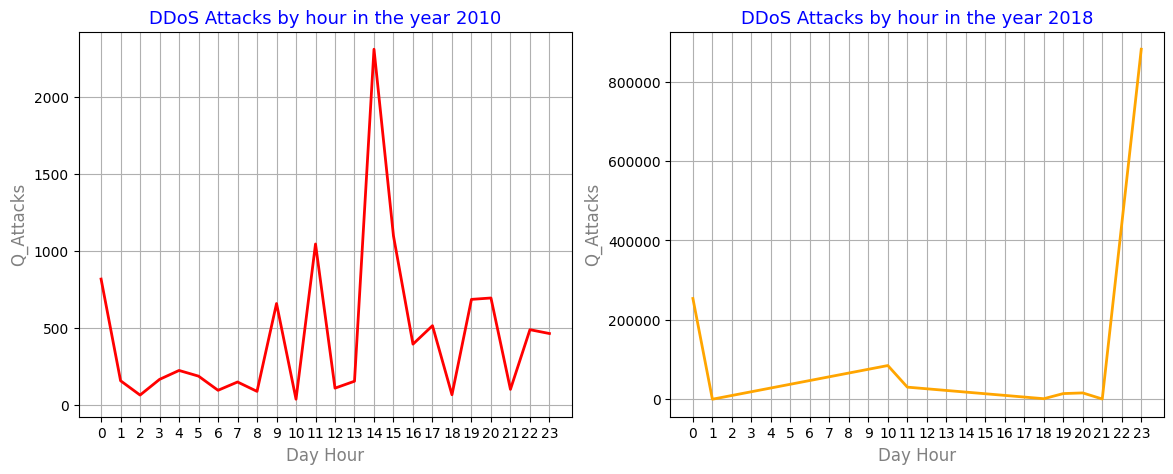

In [43]:
pivot = pd.pivot_table(data = data[data.Label == 'ddos'],
                       index=('Year','Hour'),
                       #columns=('Protocol'),
                       values = ('Protocol'),
                       aggfunc=(np.count_nonzero)
                       ).reset_index()

pivot.rename(columns={'Protocol':'Q_Attacks'}, inplace=True)

#Figure config
plt.figure(figsize=(14,5))

colors = ['red','orange','purple']
years = list(pivot['Year'].unique())
years = ['sad','ddd']

for i, year in enumerate(pivot['Year'].unique()):
    print(year)
    temp = pivot[pivot.Year == year]
    plt.subplot(1,2,i+1)
    plt.plot(temp['Hour'], temp['Q_Attacks'],linewidth =2, color = colors[i])
    plt.title('DDoS Attacks by hour in the year '+ str(year) , fontsize = 13, color = 'blue')
    plt.xlabel('Day Hour', fontsize = 12, color = 'gray')
    plt.ylabel('Q_Attacks', fontsize = 12, color = 'gray')
    plt.xticks(np.arange(24))
    plt.grid()


plt.show()


<br> Note: <br/> The attacking time was dramatically changed within 2010 and 2018

In [46]:
balance_data = data[['Flow Duration','Src IP','Src Port','Dst IP','Dst Port','Tot Fwd Pkts','Init Bwd Win Byts','Protocol','Label']]

balance_data = balance_data.astype({'Src IP':'string','Dst IP':'string','Label':'string'})

 FILTERING DATA WITH 2028 INFORMATION, BECAUSE IT HAS THE MAYORITY OF DATA

In [45]:
data_2018 =  data[data.Year == 2018]
print(data_2018.shape)

(7181780, 90)


## FEATURE SELECTION

One can try different methods, lets use:

Random Forest Classifier to test 
Correlation Heat Map


In [50]:
X = data_2018.drop(columns= ('Label'))
y = data_2018['Label']

smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X,y)

ValueError: could not convert string to float: '172.31.69.25-18.219.193.20-80-37882-6'

In [48]:
balance_data.isnull().sum()

Flow Duration        0
Src IP               0
Src Port             0
Dst IP               0
Dst Port             0
Tot Fwd Pkts         0
Init Bwd Win Byts    0
Protocol             0
Label                0
dtype: int64

In [49]:
balance_data['Src IP'].value_counts().nlargest(10)

172.31.69.25      1767182
18.219.193.20     1750476
172.31.69.28       931111
18.218.229.235     184084
18.216.200.189     183850
18.219.9.1         183140
18.218.55.126      182462
18.218.11.51       182325
18.216.24.42       182256
52.14.136.135      182177
Name: Src IP, dtype: Int64

In [52]:
balance_data['Src IP'] = balance_data['Src IP'].apply(lambda x : int(ipaddress.IPv4Address(x)))
balance_data['Dst IP'] = balance_data['Dst IP'].apply(lambda x : int(ipaddress.IPv4Address(x)))

In [53]:
balance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12794627 entries, 0 to 12794626
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Flow Duration      int64 
 1   Src IP             int64 
 2   Src Port           int64 
 3   Dst IP             int64 
 4   Dst Port           int64 
 5   Tot Fwd Pkts       int64 
 6   Init Bwd Win Byts  int64 
 7   Protocol           int64 
 8   Label              string
dtypes: int64(8), string(1)
memory usage: 878.5 MB


<AxesSubplot:>

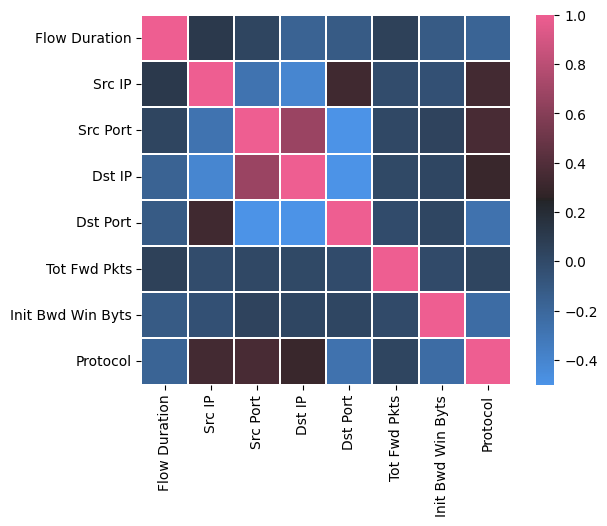

In [54]:
corr = balance_data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [56]:
# Separating the target variable 
X = balance_data.drop(columns=['Label'])
Y = balance_data.Label

# splitting the data into test and train with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state =44)

# instantiate the model
classifier = GaussianNB()

# fit the model
classifier.fit(X_train, y_train)

# predict train result
y_pred_train = classifier.predict(X_train)

y_pred_train

# predict test result
y_pred_test = classifier.predict(X_test)

y_pred_test

# accuracy score for the test and train models
print('Training-set accuracy score: {0:0.4f}%'. format(accuracy_score(y_train, y_pred_train)*100))
print('Model accuracy score: {0:0.4f}%'. format(accuracy_score(y_test, y_pred_test)*100))

Training-set accuracy score: 85.4548%
Model accuracy score: 85.4402%
